## Описание проекта

Нужно спрогнозировать количество заказов такси на следующий час. 

Значение метрики *RMSE* не больше 48.

Количество заказов находится в столбце '*num_orders*'.

# 1. Подготовка

In [50]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

#### Загрузка данных. Индексация по столбцу datetime. 

In [51]:
data = pd.read_csv('taxi.csv', index_col='datetime', parse_dates=[0])

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [53]:
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


#### Сортировка временных индексов и ресемплирование по одному часу.

In [54]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()

In [55]:
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


# 2. Анализ

#### График распределения заказов по часам.

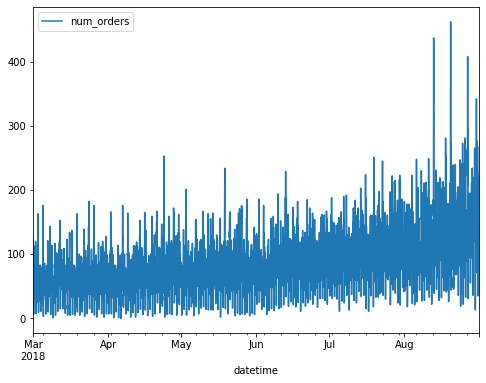

In [57]:
data.plot(figsize=(8,6))

#### Процесс нестационарный, так как заметно изменение его среднего значения. Среднее количество заказов растет.

#### Оценка сезонных факторов (общая и всрезе двух дней), трендов и шумов

In [58]:
def decomp(data):
    """
    Функция проводит декомпозицию заанного датасета и строит графики тренда, сезонности и шумов
    """
    decomposed = seasonal_decompose(data)
    plt.figure(figsize=(6, 10))

    plt.subplot(411)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')

    plt.subplot(412)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')

    plt.subplot(413)
    decomposed.seasonal['2018-03-10':'2018-03-11'].plot(ax=plt.gca())
    plt.title('2-days Seasonality')

    plt.subplot(414)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')

    plt.tight_layout()

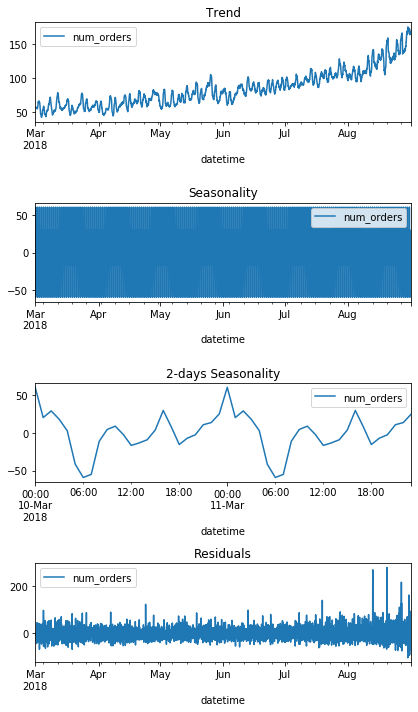

In [59]:
decomp(data)

## Выводы:
    1. Заданный процесс - стахостический нестационарный. 
    2. График тренда показывает трехкратный рост количества заказов с марта по сентябрь.
    3. Сезонность, связанная, видимо, со временем суток, в который совершались заказы - стационарна, минимальное количество заказов приходится на 6 утра, максимум - в вечерние часы 22-23.
    4. Шумы практически стационарны, и нарастают к концу временного периода. Возможно это негативно скажется на результатах предсказаний, так как в тестовую выборку войдет как раз последние 10% датасета.

# 3. Обучение

#### Добавление признаков в датасет.

In [67]:
def make_features(data, max_lag, rolling_size):
    """
    Функция добавляет признаки в датасет:
    - календарные: день, день недели;
    - отстающие значения(предыдущее, а также значение заказов в то же время каждого дня прошедшей недели плюс-минус 1 час;
    - скользящее среднее (смещение при этом равно 24-м часам)
    """
    data_temp = data.copy()
    data_temp['day'] = data.index.day
    data_temp['dayofweek'] = data.index.dayofweek
    
    
    data_temp['lag_1'] = data['num_orders'].shift()
    for lag in range(24, max_lag+1, 24):
        data_temp['lag_{}'.format(lag-1)] = data['num_orders'].shift(lag-1)
        data_temp['lag_{}'.format(lag+1)] = data['num_orders'].shift(lag+1)
        data_temp['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data_temp['rolling_mean'] = data['num_orders'].shift(24).rolling(rolling_size).mean()
    data_temp = data_temp.dropna()
    return data_temp

#### Оставлен за скобками подбор размера смещения отстающих признаков. 
Перебор проходил по наименьшему значению RMSE линейной регрессии. Подбор показал, что:
    1. Календарный признак "месяц" негативно (хоть и не значительно) влияет на предсказания. 
    2. Наилучшие предсказания, при поочередном добавлении отстающих значений, при знчении max_lag = 168. 
    3. Не все отстающие значения положительно сказывались на предсказаниях. Лучший результат показало добавление первого отстающего значения и значений целевого признака в каждый из предыдущих дней за 7 прошедших дней плюс-минус один час.
    4. При подборе размера окна скользящего среднего наилучший результат показало смещение в 24 часа.
    5. Большее влияние на качество предсказаний оказывают отстающие значения, календарные признаки и скользящее среднее улучшают RMSE незначительно

#### Разделение датасета на тренировочную и тестовую выборки

In [68]:
def split_data(data, return_train_valid = False):
    """
    Функция разделяет датасет на выборки тренировочную, валидационную и тестовую. 
    С параметром return_train_valid = False (default), возвращает тренировочную и валидационную.
    С параметром return_train_valid = True, возвращает тестовую и суммарную тренировочно-валидационную.
    """
    train_valid, test = train_test_split(
        data, 
        shuffle=False, 
        test_size=0.1)
    
    train_valid = train_valid.dropna()
    train, valid = train_test_split(
        train_valid, 
        shuffle=False, 
        test_size=0.1)
    
    if return_train_valid:
        return train_valid, test
    return train, valid

#### Выделение признаков и целевого признака

In [69]:
def feat_target(train, test):
    """
    Функция выделяет из тренировочной и тестовой выборок признаки и целевой признак.
    """
    features_train = train.drop('num_orders', axis=1)
    features_test = test.drop('num_orders', axis=1)
    target_train = train['num_orders']
    target_test = test['num_orders']
    return features_train, target_train, features_test, target_test

#### Подготовка признаков

In [70]:
def features_prepeared(data, max_lag, rolling_size, return_tv = False):
    """
    Функция, поочередным вызовом функций make_features, split_data, feat_target выделяет из датасета 
    выборки с готовыми признаками. Параметр return_tv отвечает за возврат валидационной или тестовой выборки.
    """
    data_temp = make_features(
        data, 
        max_lag, 
        rolling_size)
    
    train, test = split_data(
        data_temp, 
        return_tv)
    features_train, target_train, features_test, target_test = feat_target(train, test)
    return features_train, target_train, features_test, target_test

#### Обучение и прогнозирование линейной регрессией

In [71]:
def linReg(features_train, target_train, features_test, target_test):
    """
    Функция обучает модель линейной регресии и выдает предсказания по тренировочной и тестовой выборкам
    """
    model = LinearRegression()
    model.fit(features_train, target_train)
    pred_train = model.predict(features_train)
    pred_test = model.predict(features_test)
    return pred_train, pred_test

#### Моделирование

In [72]:
def modeling(data, max_lag, rolling_size, return_tv=False):
    """
    Функция рассчитывает RMSE модели линейной регресии
    """
    features_train, target_train, features_test, target_test = features_prepeared(data, max_lag, rolling_size, return_tv)
    
    pred_train, pred_test = linReg(
        features_train, 
        target_train, 
        features_test, 
        target_test)
    
    rmse_test = mean_squared_error(target_test, pred_test)**0.5
    rmse_train = mean_squared_error(target_train, pred_train)**0.5
    return rmse_train, rmse_test

#### Проведем подбор лучшего размера скользящего окна (проводится по транировочной и валидационной выборкам)

In [73]:
flag = 100
best_roll = 0
rmse_train = 0
for i in range (1, 200, 1):
    rmse_train, rmse_valid = modeling(data, 168 , i)
    if flag > rmse_valid:
        flag = rmse_valid
        best_roll = i
        print(rmse_train, flag, best_roll)
print('Наилучший размер скользящего окна составил ', best_roll)

20.295746631226777 28.976615296814536 1
20.292695404635246 28.97395945843852 6
20.29369902341689 28.9714833746226 7
20.293726429843524 28.969367514204272 8
Наилучший размер скользящего окна составил  8


#### Подбор гиперпараметров моделей ( так как подбор будет проводится при помощи кросс-валидации, выделять отдельную валидационную выборку не нужно)

In [74]:
features_tv, target_tv, features_test, target_test = features_prepeared(data, 168,8, return_tv=True)

#### Модели, которые будут обучены: 
    1. линейная регрессия;
    2. дерево решений;
    3. случайны лес;
    4. бэггинг дерева решений.

In [75]:
model_linear = LinearRegression()
model_forest = RandomForestRegressor(random_state = 12345, n_jobs=-1)
model_tree = DecisionTreeRegressor(random_state = 12345)
model_bagging = BaggingRegressor(random_state=12345, n_jobs=-1)

#### Выбор параметров для перебора в GridSearch

In [76]:
params_forest = {
    'n_estimators': [50,300,50],
    'max_depth':[5,15],
    'max_features' : [1,20, 2]
}

In [77]:
params_tree = {   
    'max_depth':[1,20]  
}

In [78]:
params_bagging ={
    'n_estimators': [50,300,50],
    'max_features' : [1,20],     
}

#### Подбор параметров модели дерева решений

In [79]:
CV_tree = GridSearchCV(model_tree, param_grid=params_tree, scoring = 'neg_mean_squared_error', cv=5)
CV_tree.fit(features_tv, target_tv)

C:\Users\bvfrc\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=12345,
                                             splitter='best'),
             iid='warn', n_jobs=None, param_grid={'max_depth': [1, 20]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [80]:
print('Лучшее значение RMSE:', abs(CV_tree.best_score_)**0.5)
print('С параметром', CV_tree.best_params_)

Лучшее значение RMSE: 31.021919618005672
С параметром {'max_depth': 20}


#### Подбор параметров модели бэггинга

In [81]:
CV_bagging = GridSearchCV(model_bagging, param_grid=params_bagging, scoring= 'neg_mean_squared_error', cv=5)
CV_bagging.fit(features_tv, target_tv)

C:\Users\bvfrc\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=BaggingRegressor(base_estimator=None, bootstrap=True,
                                        bootstrap_features=False,
                                        max_features=1.0, max_samples=1.0,
                                        n_estimators=10, n_jobs=-1,
                                        oob_score=False, random_state=12345,
                                        verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_features': [1, 20],
                         'n_estimators': [50, 300, 50]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [82]:
print('Лучшее значение RMSE', abs(CV_bagging.best_score_)**0.5)
print('С параметром', CV_bagging.best_params_)

Лучшее значение RMSE 22.166849181531894
С параметром {'max_features': 20, 'n_estimators': 300}


#### Подбор параметров модели случайного леса

In [83]:
CV_forest = GridSearchCV(model_forest, param_grid=params_forest, scoring='neg_mean_squared_error', cv=5)
CV_forest.fit(features_tv, target_tv)

C:\Users\bvfrc\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=-1,
                                             oob_score=False,
                                             random_state=12345, verbose=0,
                                             warm_start=False),
             iid='warn', n_jobs=None,
            

In [84]:
print('Лучшее значение RMSE:',abs(CV_forest.best_score_)**0.5)
print('С параметром', CV_forest.best_params_)

Лучшее значение RMSE: 22.211058450084913
С параметром {'max_depth': 15, 'max_features': 20, 'n_estimators': 300}


#### Также проведем кросс-валидацию модели линейной регрессии

In [85]:
def cr_val_sc(model, features, target):
    """
    Функция проводит кросс-валидацию и считает среднюю метрику
    """
    score = cross_val_score(model, features, target, cv=5, scoring = 'neg_mean_squared_error')
    final_score = score.mean()
    return abs(final_score)**0.5

In [86]:
print('RMSE линейной регрессии: ',cr_val_sc(model_linear, features_tv, target_tv))

RMSE линейной регрессии:  21.592874608544513


## Вывод.
    1. Выбраны признаки для обучения моделей:
        - календарные: день, день недели;
        - отстающие значения(предыдущее, а также значение заказов в то же время каждого дня прошедшей недели плюс-минус 1 час;
        - скользящее среднее (смещение при этом равно 24-м часам).
    2. Признаки добавлены.
    3. Выбраны модели для обучения : линейна регрессия, дерево решений, случайны лес, бэггинг деревьев.
    4. Проведена кросс-валидация. При этом перемешивание не мешает предсказаниям, так как признаки, зависящие от предыдущих значений уже добавлены.
    5. Выбрана наилучшая модель - модель линейной регрессии.

# 4. Тестирование

#### Построим константные модели для оценки прогноза на адекватность

In [87]:
pred_median = np.ones(target_test.shape) * target_tv.median()
rmse_median = mean_squared_error(target_test, pred_median)**0.5
print('Модель предсказаний медианным значением имеет RMSE =',rmse_median)

Модель предсказаний медианным значением имеет RMSE = 87.03915278566916


In [88]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_tv.iloc[-1]
rmse_previous = mean_squared_error(target_test, pred_previous)**0.5
print('Модель предсказаний предыдущим значением имеет RMSE =',rmse_previous)

Модель предсказаний предыдущим значением имеет RMSE = 58.819724582830204


#### Проверка наилучшей модели на тестовой выборке

In [89]:
model_best = LinearRegression()
model_best.fit(features_tv, target_tv)
pred_train = model_best.predict(features_tv)
pred_test = model_best.predict(features_test)

In [90]:
rmse_test = mean_squared_error(target_test, pred_test)**0.5
rmse_train = mean_squared_error(target_tv, pred_train)**0.5

In [91]:
print('RMSE модели на тренировочной выборке составило ', rmse_train)

RMSE модели на тренировочной выборке составило  21.2984860190179


In [92]:
print('RMSE модели на тестовой выборке составило ', rmse_test)

RMSE модели на тестовой выборке составило  35.283903579925436


## Вывод. 
    1. Константные модели показали:
        - RMSE медианной модели = 86
        - RMSE модели предсказания предыдущим значением = 58
    2. Лучшая выбранная модель линейной регрессии на тестовой выборке показала RMSE = 35,5.
    3. Модель можно признать адекватной, она предсказывает лучше константных моделей.
    4. Модель показала RMSE менее заданных 48.